In [1]:
import os
from pathlib import Path
from dataclasses import dataclass

import torch

from gtp.configs.loaders import load_configs
from gtp.configs.project import GenotypeToPhenotypeConfigs
from gtp.dataloading.path_collectors import (
    get_experiment_directory,
    get_post_processed_genotype_directory,
)
from gtp.dataloading.tools import collect_chromosome
from gtp.models.net import SoyBeanNet
from gtp.options.process_attribution import ProcessAttributionOptions
from gtp.evaluation import get_lrp_attr

# SPECIFY GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


class GeneEditingDashboardState:
    def __init__(
        self,
        wing: str,
        species: str,
        color: str,
        chromosome: int,
        exp_name: str,
        config_path: str,
    ):
        self.wing = wing
        self.species = species
        self.color = color
        self.chromosome = chromosome
        self.exp_name = exp_name
        self.configs: GenotypeToPhenotypeConfigs = load_configs(config_path)
        self.model = None
        self.camids = None
        self.data = None

        self.load_data_and_model()

    def load_data_and_model(self):
        match self.exp_name:
            case "base":
                drop_out_prob = 0.75
                out_dims = 1
                out_dims_start_idx = 0
                insize = 3
                hidden_dim = 10
            case "pca_10":
                drop_out_prob = 0.75
                out_dims = 10
                out_dims_start_idx = 0
                insize = 3
                hidden_dim = 10
            case _:
                raise NotImplementedError(
                    f"Experiment {self.exp_name} isn't implemented for this visualization. Please create a case and update configs."
                )

        opts: ProcessAttributionOptions = ProcessAttributionOptions(
            drop_out_prob=drop_out_prob,
            out_dims=out_dims,
            out_dims_start_idx=out_dims_start_idx,
            insize=insize,
            hidden_dim=hidden_dim,
            species=self.species,
            chromosome=self.chromosome,
            color=self.color,
            wing=self.wing,
            exp_name=self.exp_name,
        )

        processed_genotype_dir = (
            get_post_processed_genotype_directory(self.configs.io)
            / self.configs.experiment.genotype_scope
        )

        # Collect genotype data
        self.camids, self.data = collect_chromosome(
            processed_genotype_dir, self.species, self.chromosome
        )

        self.model = SoyBeanNet(
            window_size=self.data.shape[1],
            num_out_dims=opts.out_dims,
            insize=opts.insize,
            hidden_dim=opts.hidden_dim,
            drop_out_prob=opts.drop_out_prob,
        )

        experiment_dir = get_experiment_directory(
            self.configs.io,
            species=self.species,
            wing=self.wing,
            color=self.color,
            chromosome=self.chromosome,
            exp_name=self.exp_name,
        )

        self.model.load_state_dict(
            torch.load(experiment_dir / "model.pt", weights_only=True)
        )
        self.model = self.model.cuda()


"""
EDIT HERE
"""
gene_editing_dashboard_state = GeneEditingDashboardState(
    wing="forewings",
    species="erato",
    color="color_3",
    chromosome=18,
    exp_name="pca_10",
    config_path=Path("../configs/default.yaml"),
)

In [2]:
from pathlib import Path

from torch.utils.data import DataLoader

from gtp.configs.loaders import load_configs
from gtp.configs.project import GenotypeToPhenotypeConfigs
from gtp.dataloading.data_collectors import load_training_data
from gtp.dataloading.datasets import GTP_Dataset
from gtp.options.process_attribution import ProcessAttributionOptions

config_path = Path("../configs/default.yaml")
cfgs: GenotypeToPhenotypeConfigs = load_configs(config_path)
opts: ProcessAttributionOptions = ProcessAttributionOptions(
    species="erato",
    color="color_3",
    wing="forewings",
    chromosome=18,
    exp_name="base",
    verbose=True,
    drop_out_prob=0.75,
    out_dims=10,
    out_dims_attribution=1,
    out_dims_start_idx=0,
    out_dims_start_idx_attribution=0,
    insize=3,
    hidden_dim=10,
)

train_data, val_data, test_data = load_training_data(cfgs, opts)
dset = GTP_Dataset(*test_data)
dloader = DataLoader(dset, batch_size=8, num_workers=4)

In [17]:
gene_editing_dashboard_state.model.train()
att_results_model_train = [
    get_lrp_attr(gene_editing_dashboard_state.model, dloader, targets=0, verbose=True)
    for _ in range(10)
]

gene_editing_dashboard_state.model.eval()
att_results_model_eval = get_lrp_attr(
    gene_editing_dashboard_state.model, dloader, targets=0, verbose=True
)

Calculating LRP Attributions: 6it [00:02,  2.71it/s]Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/carlyn.1/miniconda3/envs/gtp/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*

/home/carlyn.1/tmp/ipykernel_749234/2422339044.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig("test.png")


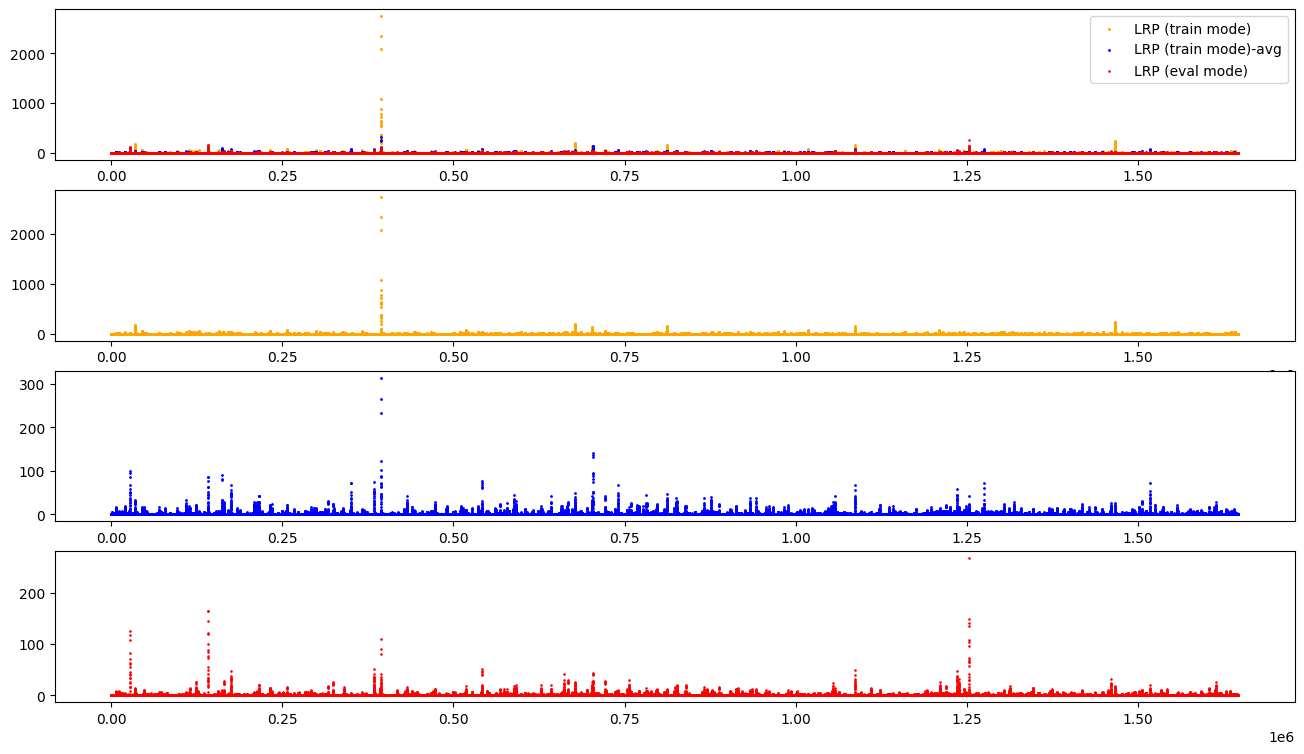

In [18]:
import matplotlib.pyplot as plt
import numpy as np

train_mode_y = att_results_model_train[0][0]
train_avg_mode_y = np.array(att_results_model_train).mean(0)[0]
eval_mode_y = att_results_model_eval[0]
x = np.arange(len(train_mode_y))

fig, ax = plt.subplots(4, 1, figsize=(16, 9))
ax[0].scatter(x=x, y=train_mode_y, s=1.25, label="LRP (train mode)", color="orange")
ax[0].scatter(x=x, y=train_avg_mode_y, s=1, label="LRP (train mode)-avg", color="blue")
ax[0].scatter(x=x, y=eval_mode_y, s=0.75, label="LRP (eval mode)", color="red")
ax[1].scatter(x=x, y=train_mode_y, s=1.25, label="LRP (train mode)", color="orange")
ax[2].scatter(x=x, y=train_avg_mode_y, s=1, label="LRP (train mode)-avg", color="blue")
ax[3].scatter(x=x, y=eval_mode_y, s=0.75, label="LRP (eval mode)", color="red")
ax[0].legend()
fig.savefig("test.png")
fig.show()